> This is my first published notebook on Kaggle! Please Upvote if you like. 
> 
> I am open to any feedback which can help me improve!
>
> Thanks in advance.

## Guide to set up Kaggle on Google Colab (Run this section only if you are using Google Colab)

In [ ]:
##Install Kaggle Library on Google Colab

# !pip install kaggle

In [ ]:
## Upload Kaggle.json file from Kaggle API Token

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

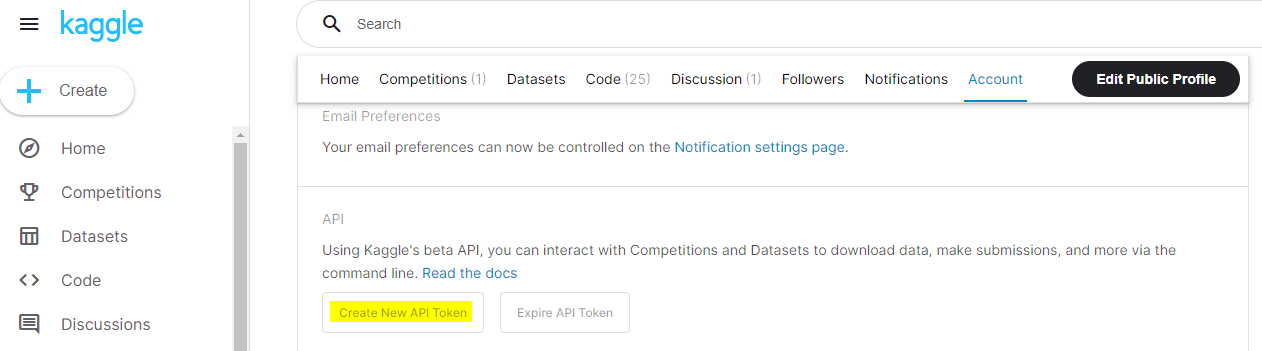

In [ ]:
##Run this command to get a list of kaggle competitions

# !kaggle competitions list

In [ ]:
##Copy-Paste this command from 'Data' tab of the competition

# !kaggle competitions download -c tabular-playground-series-jan-2021

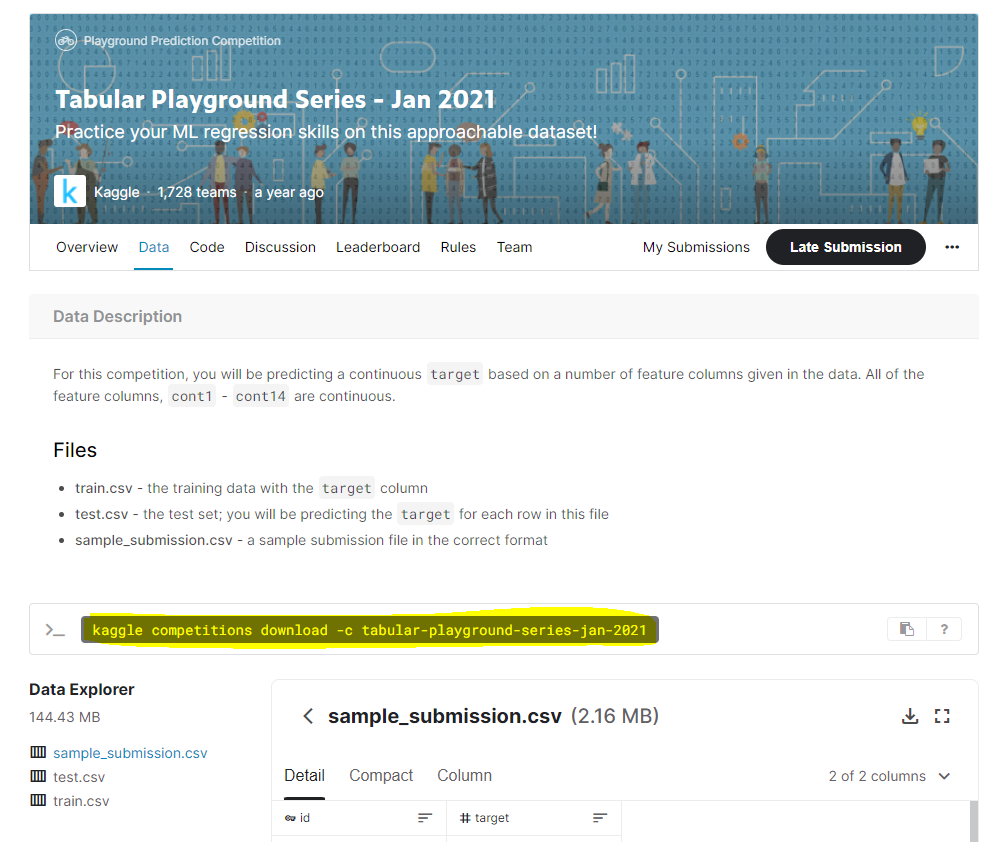

In [ ]:
##Unzip the competition data

# !unzip /content/tabular-playground-series-jan-2021.zip

# Importing Libraries

In [ ]:
#Importing Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("RdYlBu_r")

# Reading the data files

In [ ]:
#Reading the data files (Change the paths if running on google colab)

train = pd.read_csv('../input/tabular-playground-series-jan-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-jan-2021/test.csv')
sample = pd.read_csv('../input/tabular-playground-series-jan-2021/sample_submission.csv')

# Exploring the data

In [ ]:
print(f'Shape of train data: {train.shape}')
print(f'Missing values count: {train.isna().sum().sum()}')

train.head()

In [ ]:
train.info()
print('\n')
train.nunique()

* Training data has 300000 records and 16 features. 
* Column 'id'is the primary key.
* It's a regression problem since we need to predict the 'target' feature which is continous in nature.
* There are 14 numerical features which are already scaled.
* There is no missing value in this data and all features are numerical.

In [ ]:
print(f'Shape of test data: {test.shape}')
print(f'Missing values count: {test.isna().sum().sum()}')

test.head()

In [ ]:
test.info()
print('\n')
test.nunique()

* Test data has 200000 records and 15 features. 'Target' feature is absent as expected.
* Column 'id' is the primary key.
* There are 14 numerical features which are already scaled.
* There is no missing value in this data and all features are numerical.

In [ ]:
sample.head()

* We need to submit the predicted target value for each id in the test data.

# Pre- Modeling

Before jumping into EDA, let's do a dry run to see how the Naive model and some basic models perform.

## Train Test Split

In [ ]:
#Separating the target variable and removing the 'id' column
y = train['target']
X = train.drop(['target', 'id'], axis = 1)

In [ ]:
#Splitting the training data into 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Naive Model

This Naive model will 'predict' the median target value for all the records in test data.

**This step is important to set up a benchmark score and improve further on that.**

In [ ]:
# Let's get a benchmark score
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(X_train, y_train)
y_dummy = model_dummy.predict(X_test)
score_dummy = mean_squared_error(y_test, y_dummy, squared=False)
print(f'{score_dummy:0.5f}')

In [ ]:
test.shape, train.shape

In [ ]:
#Submitting the prediction
sample['target'] = model_dummy.predict(test.drop('id', axis = 1))
sample.to_csv('dummy.csv', index = False)

After submitting the results, we get a leaderboard score of 0.73487.

# Simple ML Models

Let's start with some simple ML models to see how well they perform with respect to the naive model score.

In [ ]:
model_names = ["Linear",  "Lasso", "Ridge", "Decision Tree"]

models = [
    LinearRegression(fit_intercept=True),
    Lasso(fit_intercept=True),
    Ridge(fit_intercept=True),
    DecisionTreeRegressor()]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)
    print(f'{name}: RMSE: {score}')

In [ ]:
#Submitting the results from the best performing model so far.
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
sample['target'] = model.predict(test.drop('id', axis = 1))
sample.to_csv('simple_ml_model.csv', index = False)

After submitting the results, we get a leaderboard score of 0.72703.
Not a bad start! We have beaten the benchmark score by 0.00784

Let's take this improved score as our new benchmark.

# Exploratory Data Analysis (EDA)

In [ ]:
#Setting the 'id' primary key as an index

train = train.set_index('id')
test = test.set_index('id')

In [ ]:
#Checking if there is any difference between the behaviour of train and test data
train.describe()-test.describe()

There is not a major difference in the values of all features of test and train data. This is a good sign and will help us in correct validation.

In [ ]:
#Let's check the distribution of target variable

sns.distplot(train['target'], kde=True, bins=120, label='train')
plt.xlabel('Target', fontsize=9); plt.legend()

The distribution of the target variable is bimodal.

In [ ]:
# Checking the distribution of other features

i = 1
plt.figure()
fig, ax = plt.subplots(5, 3, figsize=(14, 24))
for feature in test.columns:
    plt.subplot(5, 3, i)
    sns.distplot(train[feature], kde=True, bins=120, label='train')
    sns.distplot(test[feature], kde=True, bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

* Just like the target variable, all other features are either bimodal or multimodal in nature. 
* Train and test data values are overlapping.

### Scaling

In [ ]:
#Let's scale these values to convert them into normal distribution

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train.drop('target', axis = 1))

train[train.drop('target', axis = 1).columns] = scaler.transform(train.drop('target', axis = 1))

test_scaled = scaler.transform(test)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

### Correlation Check

In [ ]:
#Let's check how the features are inter-related to each other and with target variable
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train[train.columns[train.columns != 'id']].corr(), vmin=-1, vmax=1, annot=True, cmap = 'Blues')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

* Features cont6 and cont9 are strongly correlated with other features and less correlated with target. Let's drop them.

In [ ]:
#Dropping the correlated features.
train = train.drop(['cont6', 'cont9'], axis = 1)
test = test.drop(['cont6', 'cont9'], axis = 1)

### Outlier Treatment

In [ ]:
# Checking outliers using Box Plots

i = 1
plt.figure()
fig, ax = plt.subplots(5, 3, figsize=(14, 24))
for feature in train.columns:
    plt.subplot(5, 3, i)
    sns.boxplot(train[feature])
    plt.xlabel(feature, fontsize=9)
    i += 1
plt.show()

In [ ]:
#Checking for mild outliers
Q1_train = train.quantile(0.25)
Q3_train = train.quantile(0.75)
IQR_train = Q3_train - Q1_train

((train < Q1_train - 1.5*IQR_train) | (train > Q3_train + 1.5*IQR_train)).agg([sum, 'mean', 'count'])

In [ ]:
#Checking for extreme outliers
Q1_train = train.quantile(0.25)
Q3_train = train.quantile(0.75)
IQR_train = Q3_train - Q1_train

((train < Q1_train - 3*IQR_train) | (train > Q3_train + 3*IQR_train)).agg([sum, 'mean', 'count'])

The Target Feature has some extreme outliers and 'cont7', 'cont10' has some mild outliers.

Let's remove the records having target feature outlier and replace the outliers in 'cont7' and 'cont10' with median value.

In [ ]:
# Removing records with extreme outliers in target variable
train = train.drop(train[(train['target'] < (Q1_train - 3*IQR_train)['target']) | (train['target'] > (Q1_train + 3*IQR_train)['target'])].index)

Removed 2 records.

In [ ]:
#Replacing outliers with median value

def replace_outliers(data):
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        median_ = data[col].median()
      
        data.loc[((data[col] < Q1 - 3*IQR) | (data[col] > Q3 + 3*IQR)), col] = median_
    return data

train[train.drop('target', axis = 1).columns] = replace_outliers(train.drop('target', axis = 1))

In [ ]:
#Checking the distribution of target variable again
sns.distplot(train['target'], kde=True, bins=120, label='train')
plt.xlabel('Target', fontsize=9); plt.legend()

Target Distribution is much lesser skewed now.

# Modeling

Let's try the ensemble models (like Random Forest, Light GBM, XGBoost) this time.

In [ ]:
train = train.reset_index()

In [ ]:
#Separating the target variable and removing the 'id' column
y = train['target']
X = train.drop(['target', 'id'], axis = 1)

In [ ]:
# Splitting the train data in 80:20 ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [ ]:
model_names = ["LGBM", "Random Forest", "XGBoost"]

models = [
    LGBMRegressor(),
    RandomForestRegressor(n_estimators = 10, max_depth = 10),
    XGBRegressor()]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)
    print(f'{name}: RMSE: {score}')

Woah!! Looks like the LightGBM model is fitting this data really well. Let's try submitting this model results.

In [ ]:
model = LGBMRegressor()
model.fit(X, y)
sample['target'] = model.predict(test.drop('id', axis = 1, errors = 'ignore'))
sample.to_csv('lgbm.csv', index = False)

Great! We have got a leaderboard score of 0.70453. Much better than our previous benchmark score.

Since the LGBM model is showing good potential, let's dive deep into the hyperparameter tuning of this best model. 

## LGBM Hyperparameter Tuning using Optuna

In [ ]:
## Install optuna library
# !pip install optuna

In [ ]:
#Importing optuna library
import optuna

In [ ]:
#Function for hyperparameter tuning using optuna

def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 2000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
#Hyperparameter tuning to minimize the RMSE for predictions

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
#Checking the best set of hyperparameters

print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
#Adding some additional parameters

params=study.best_params   
params['random_state'] = 48
params['n_estimators'] = 2000
params['metric'] = 'rmse'

In [ ]:
#Training LGBM with best set of hyperparameters

model = LGBMRegressor(**params)
model.fit(X, y)
sample['target'] = model.predict(test.drop('id', axis = 1, errors = 'ignore'))
sample.to_csv('submission.csv', index = False)

Awesome! The leaderboard score has improved to 0.70086 after tuning the LGBM Regressor.

### The End!

Thank you for reading this notebook. I have learnt alot from this exercise, hope you have learnt something too.
Please share feedback if you find any flaw or have a better approach.

### Please upvote if you liked. It will motivate me to do better :)
![](http://68.media.tumblr.com/e1aed171ded2bd78cc8dc0e73b594eaf/tumblr_o17frv0cdu1u9u459o1_500.gif)